# House Pricing - EDA

## Overview

This dataset is the basis for our prediction of house prices.To summarize data.

### Summary

Number of features: 80  

Label: `SalePrice`

Types of data:
  - **Numeric:** `LotArea`, `GarageArea`, `GrLivArea`, ...
  - **Categorical:** `RoofStyle`, `HouseStyle`, `SaleCondition`, ...

---

### Feature Group Summary

- **Land and Lot Information**
  - `LotArea`, `LotFrontage`, `LotShape`, `LandContour`, `Neighborhood`
  - Description: Details about lot size, shape, and location.

- **Building and Design**
  - `BldgType`, `HouseStyle`, `OverallQual`, `OverallCond`, `YearBuilt`, `YearRemodAdd`
  - Description: Type and style of the house, overall quality, and construction/remodel year.

- **Exterior and Materials**
  - `RoofStyle`, `Exterior1st`, `MasVnrType`, `ExterQual`, `Foundation`
  - Description: Roof type, exterior materials, and foundation quality.

- **Basement**
  - `BsmtQual`, `BsmtFinSF1`, `BsmtExposure`, `TotalBsmtSF`
  - Description: Basement size, finish type, and quality.

- **Living Area**
  - `1stFlrSF`, `2ndFlrSF`, `GrLivArea`, `TotRmsAbvGrd`
  - Description: Total living area and number of rooms above ground.

- **Bathrooms and Kitchen**
  - `FullBath`, `HalfBath`, `KitchenQual`, `BsmtFullBath`
  - Description: Number and quality of bathrooms and kitchens.

- **Garage and Other Features**
  - `GarageCars`, `GarageArea`, `Fireplaces`, `PoolArea`, `Fence`
  - Description: Garage capacity, number of fireplaces, and details about the pool and fence.

- **Sale Information**
  - `MoSold`, `YrSold`, `SaleType`, `SaleCondition`
  - Description: Month and year sold, sale type, and sale condition.

---

**Note:** You can read the detailed data description in the folder `"data/raw/data_description.txt"`.


<img src="image/HS_illustration.jpg" width="800">

## Preparation

### Import needed libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
from os.path import join
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
from scipy.spatial.distance import squareform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.cluster.hierarchy as sch

### Load the dataset

In [2]:
data_dir = join('..', '..', 'data')
input_dir = join(data_dir, 'raw')

train = pd.read_csv(join(input_dir, 'train.csv'))
test = pd.read_csv(join(input_dir, 'test.csv'))

df_train = train.copy()
df_test = test.copy()

df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

For now, we will drop ID column as it's unnecessary

In [4]:
df_train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [5]:
df_train = df_train.drop(['Id'], axis=1)
df_test = df_test.drop(['Id'], axis=1)

- Libraries imported and data loaded from data/raw/train.csv + test.csv.

- Dropped `Id` column (not predictive).

- Data ready for EDA: inspect missing%, distributions and relationships before preprocessing/FE.

## Univariate

In this section, my team wants to directly distribute the SalePrice targets and key variables.

The purpose is to:

- Understand the distribution of house prices to help choose the appropriate prediction method.

- Detect variables with skewed distribution (skewed right or left) that need to be log-transformed.

### Distribution of SalePrice - target variable

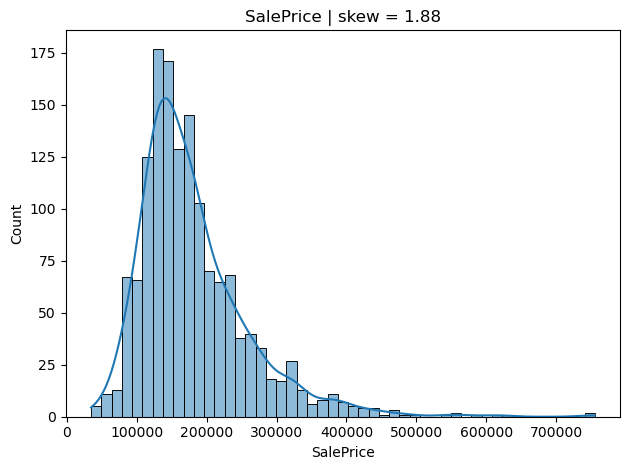

In [6]:
sale = df_train['SalePrice'].dropna()
skew = sale.skew()

sns.histplot(df_train['SalePrice'], kde=True);
plt.title(f"SalePrice | skew = {skew:.2f}")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

- Target `SalePrice` is right-skewed (skew ≈ 1.88).  

- Recommend log-transform (e.g., np.log1p) before modeling to stabilize variance and reduce influence of high-priced outliers.  

- After log-transform, re-check normality and residual behavior.

### Detecting missing value

In [7]:
print(df_train.isnull().sum()[df_train.isnull().sum() > 0])

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [8]:
print(df_test.isnull().sum()[df_test.isnull().sum() > 0])

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType       894
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64


- Several columns have non-trivial missingness (e.g., LotFrontage ≈ 17%; Alley/PoolQC/FireplaceQu many NAs).  

- Actionable plan:

  - Print missing % table and use it to decide. 

  - Drop columns with very high missing% (>20–30%) or treat as special indicator (e.g., no-feature).  

  - For numeric with moderate missingness use median or model-based imputation; for categorical fill with 'None' or mode as appropriate.  
  
  - Ensure consistent imputation for train/test.

### Detecting outlier values

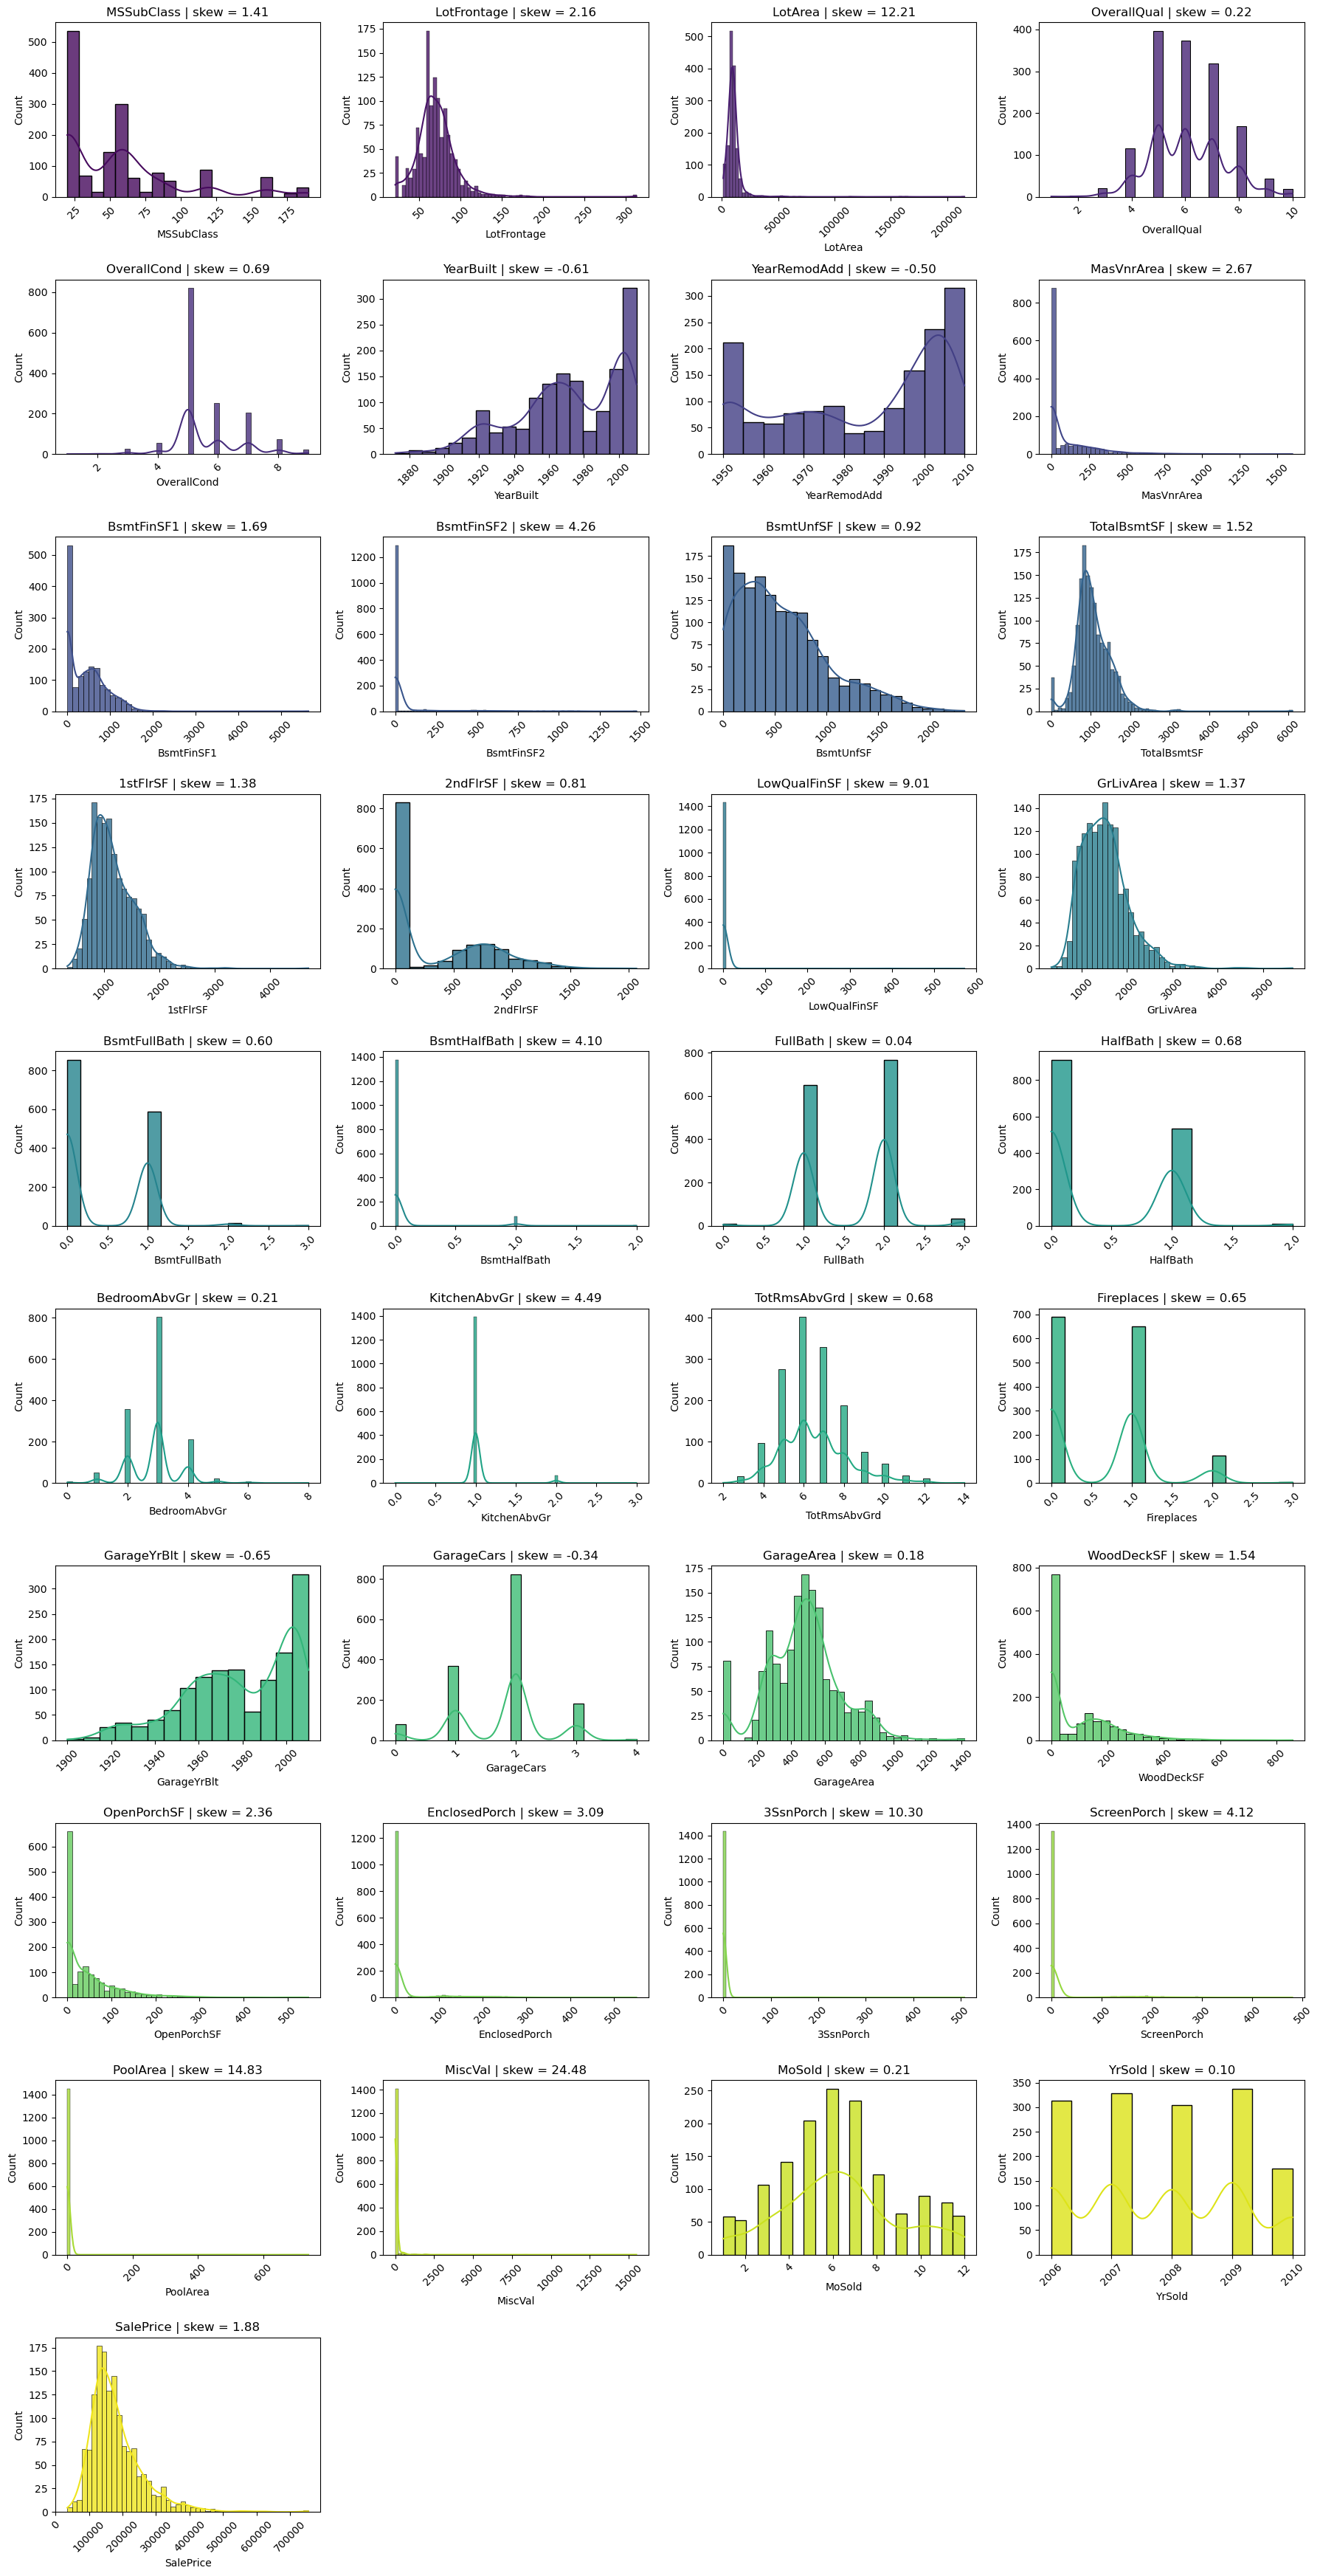

In [9]:
numerical_columns = df_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
n_cols = 4
n_rows = int(np.ceil(len(numerical_columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 3.5))
axes = axes.flatten()
palette = sns.color_palette("viridis", n_colors=len(numerical_columns))

for i, feature in enumerate(numerical_columns):
    ax = axes[i]
    data = df_train[feature].dropna()
    sns.histplot(data, kde=True, ax=ax, color=palette[i], edgecolor='k', alpha=0.8)
    ax.set_title(f"{feature} | skew = {df_train[feature].skew():.2f}")
    ax.tick_params(axis='x', rotation=45)

# remove extra axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Usually, skewness in range (-2, 2) are acceptable. Based on that condition, here's features that are high-skewed:

- LotFrontage: Linear feet of street connected to property
- LotArea: Lot size in square feet
- MasVnrArea: Masonry veneer area in square feet
- BsmtFinSF2: Type 2 finished square feet
- LowQualFinSF: Low quality finished square feet (all floors)
- BsmtHalfBath: Basement half bathrooms
- KitchenAbvGr
- OpenPorchSF: Open porch area in square feet
- EnclosedPorch: Enclosed porch area in square feet
- 3SsnPorch: Three season porch area in square feet
- ScreenPorch: Screen porch area in square feet
- PoolArea: Pool area in square feet
- MiscVal: $Value of miscellaneous feature

### Numerical distribution

In [10]:
df_num = df_train.select_dtypes(include = ['float64', 'int64'])
df_num.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315  ...   
std      30.202904     20.645407   181.066207   456.098091   161.319273  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1954.000000   1967.000000     0.000000     0.000000     0.000000  ...   
50%    1973.000000   1994.000000     0.000000   383.500000     0.000000  ...   
75%    2000.000000   2004.000000   166.000000   712.250000     0.000000  ...   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 37 columns]

Based on the output, we can see that there are 38 numeric features, that being said there'll have 43 categorical features. Also, some features are high-skewed. More analysis will be done to figure it more.

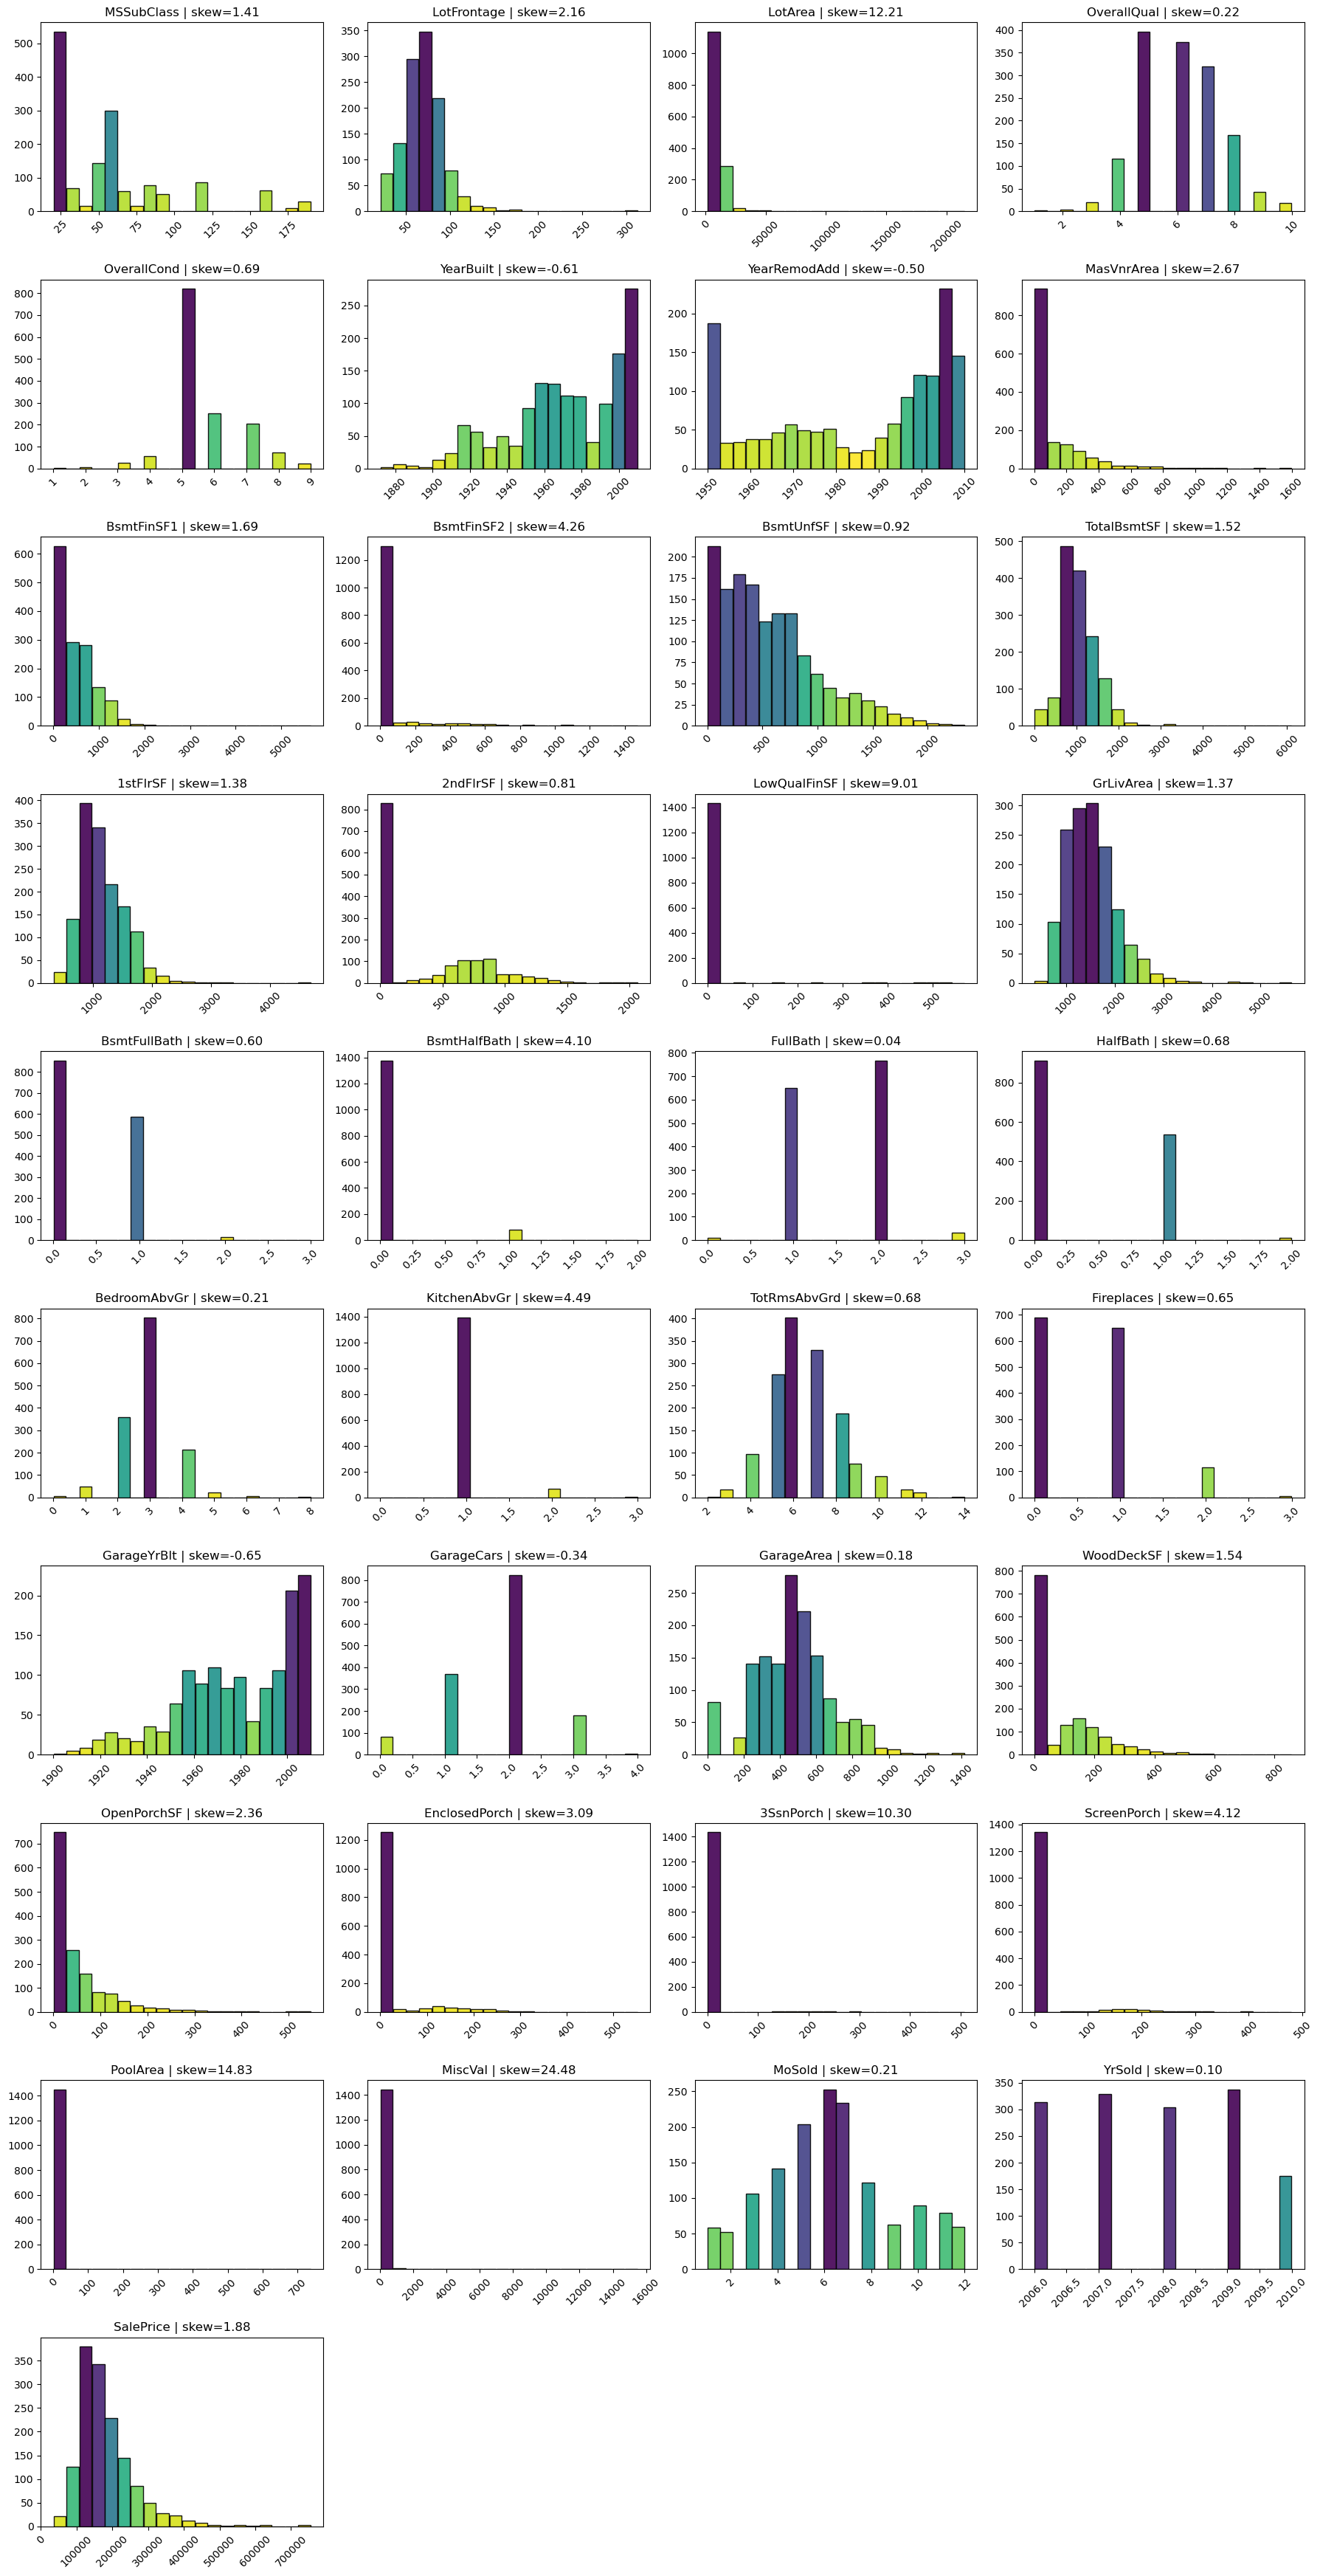

In [11]:
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
n_cols = 4
n_rows = int(np.ceil(len(numeric_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 3.5))
axes = axes.flatten()
bins = 20
cmap = plt.cm.get_cmap('viridis_r')

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    data = df_train[col].dropna()
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    norm = plt.Normalize(vmin=counts.min() if len(counts) else 0, vmax=counts.max() if len(counts) else 1)
    colors = cmap(norm(counts))
    ax.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]) * 0.95, color=colors, edgecolor='k', alpha=0.9)
    ax.set_title(f"{col} | skew={df_train[col].skew():.2f}")
    ax.tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Look at the graph, we can see that although there are numeric features, but the unique values are so little that I thought there are categorical features.
- **MSSubClass**: Identifies the type of dwelling involved in the sale.
- **OverallQual**: Rates the overall material and finish of the house
- **OverallCond**: Rates the overall condition of the house
- **BsmtFullBath**: Basement full bathrooms
- **BsmtHalfBath**: Basement half bathrooms
- **FullBath**: Full bathrooms above grade
- **HalfBath**: Half baths above grade
- **TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)
- **Fireplaces**: Number of fireplaces
- **GarageCars**: Size of garage in car capacity
- **MoSold**: Month Sold (MM)
- **YrSold**: Year Sold (YYYY)

List of features that does not include in the description file:
- **BedroomAbvGr**
- **KitchenAbvGr**

To make sure that these features are really categorical, we analyze unique values of these features

In [12]:
df_train[['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold', 'BedroomAbvGr', 'KitchenAbvGr']].nunique()

MSSubClass      15
OverallQual     10
OverallCond      9
BsmtFullBath     4
BsmtHalfBath     3
FullBath         4
HalfBath         3
TotRmsAbvGrd    12
Fireplaces       4
GarageCars       5
MoSold          12
YrSold           5
BedroomAbvGr     8
KitchenAbvGr     4
dtype: int64

Base on the given description file, we've detected these features as categorical (for sure):
- MSSubClass
- OverallQual
- OverallCond

As for the rest, we will leave that as it is, the main model we will train is regression models, which could be beneficial by numeric features.


### Summary

- Summarized numeric attributes using `describe()` and plotted histograms for all variables.

- Preliminary conclusions: there are 38 numeric variables; many are skewed and some have outliers.

- Suggested actions:

    - For highly skewed variables (e.g. SalePrice) apply log-transform.

    - For variables with outliers, consider IQR or transform before training.

### Classification distribution

In [13]:
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()
print(f"Number of categorical features: {len(cat_cols)}")
print("\nTop unique counts (categorical):")
print(df_train[cat_cols].nunique().sort_values(ascending=False).head(30))

Number of categorical features: 43

Top unique counts (categorical):
Neighborhood     25
Exterior2nd      16
Exterior1st      15
SaleType          9
Condition1        9
Condition2        8
HouseStyle        8
RoofMatl          8
Functional        7
BsmtFinType2      6
Heating           6
RoofStyle         6
SaleCondition     6
BsmtFinType1      6
GarageType        6
Foundation        6
Electrical        5
FireplaceQu       5
HeatingQC         5
GarageQual        5
GarageCond        5
MSZoning          5
LotConfig         5
ExterCond         5
BldgType          5
BsmtExposure      4
MiscFeature       4
Fence             4
LotShape          4
LandContour       4
dtype: int64


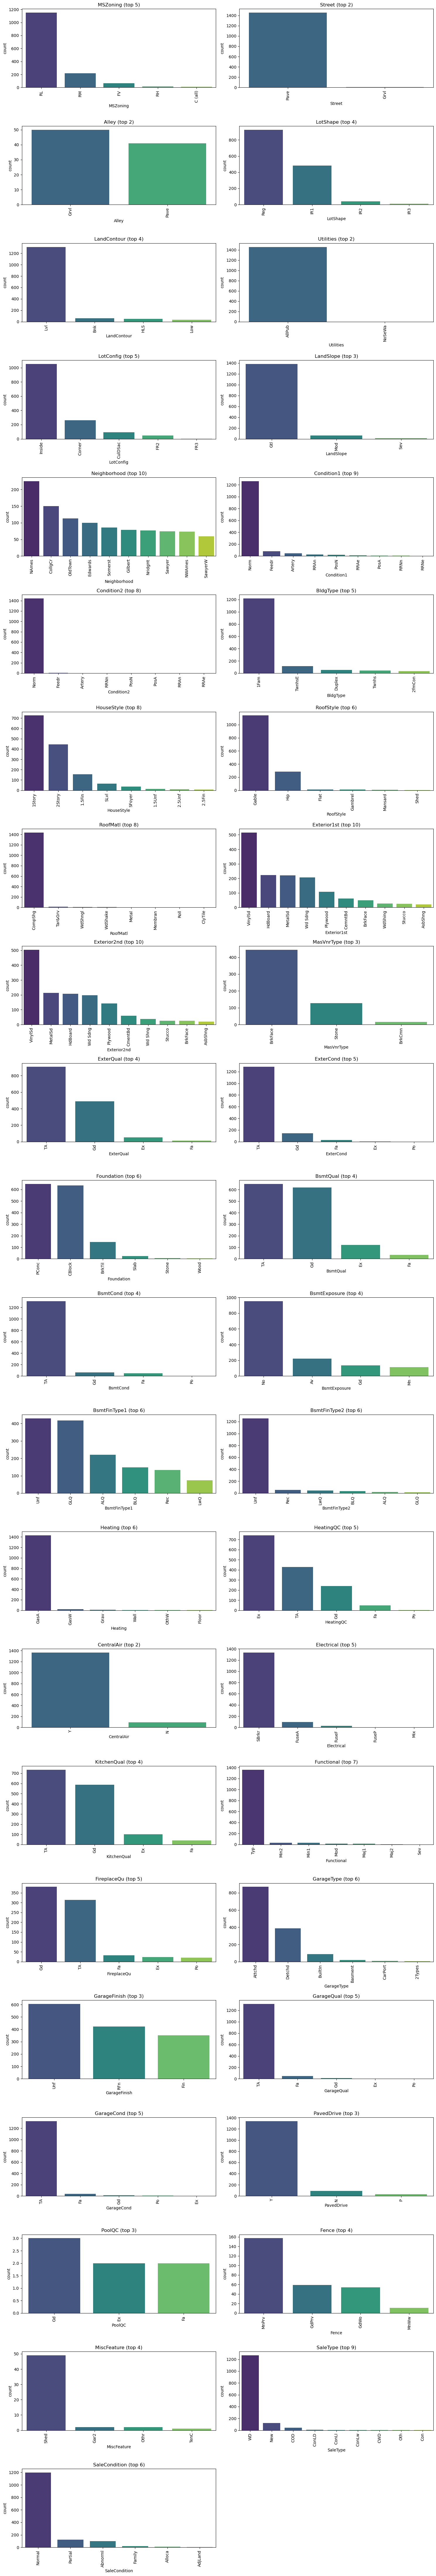

In [14]:
top_k = 10
n_cols = 2
n_rows = int(np.ceil(len(cat_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    order = df_train[col].value_counts().index[:top_k]
    sns.countplot(x=col, data=df_train, order=order, ax=axes[i], palette="viridis")
    axes[i].set_title(f"{col} (top {min(top_k, df_train[col].nunique())})")
    axes[i].tick_params(axis='x', rotation=90)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Many categorical variables are imbalanced or high-cardinality.  

- Actions:

  - For low-cardinality categoricals: one-hot encode or ordinal map when order exists.  

  - For high-cardinality: group rare levels (threshold) or use target/mean/leave-one-out encoding at modeling stage.  
  
  - For extremely imbalanced classes consider combining rare labels into 'Other'.

## Bivariate

In this section, our team focuses on assessing the correlation between `SalePrice` and quantitative variables, and observing the nonlinear relationships between `SalePrice` and qualitative variables.

### Correlation heatmap — top numeric features by |corr| with SalePrice

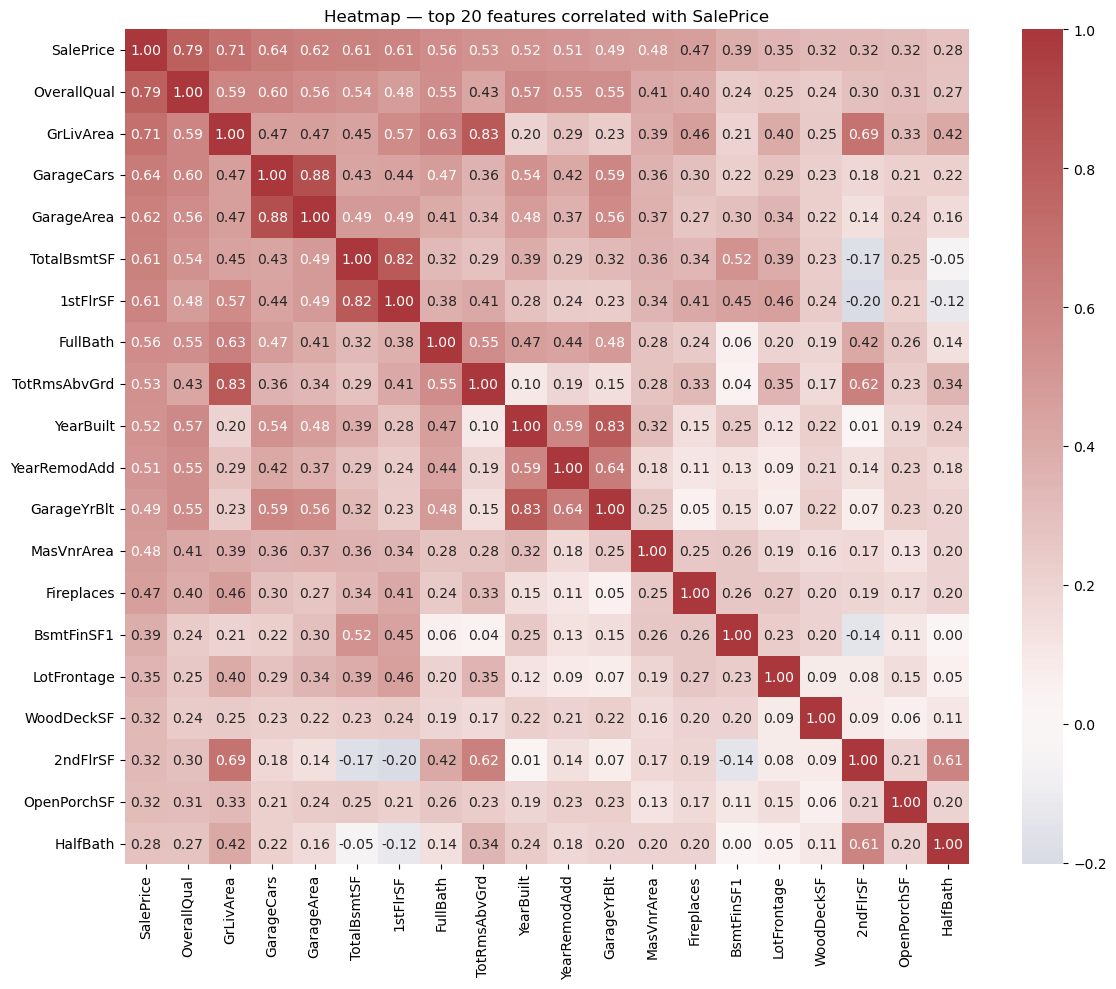

Top correlations with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64


In [15]:
corr = df_train.select_dtypes(include=[np.number]).corr()
top_feats = corr['SalePrice'].abs().sort_values(ascending=False).head(20).index.tolist()

plt.figure(figsize=(12,10))
sns.heatmap(df_train[top_feats].corr(), annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title("Heatmap — top 20 features correlated with SalePrice")
plt.tight_layout()
plt.show()

print("Top correlations with SalePrice:")
print(corr['SalePrice'].abs().sort_values(ascending=False).head(15))

- `OverallQual` is the strongest single numeric correlate with SalePrice.  

- Area-related variables (`GrLivArea`, `TotalBsmtSF`, `1stFlrSF`) form a high-correlation cluster — multicollinearity likely.  

- `GarageCars` and `GarageArea` are nearly redundant.  

- Action: compute VIF on cleaned numeric set to decide which to drop/merge or later use regularization.

### VIF Calculation

In [ ]:
X = df_train.select_dtypes(include=[np.number]).drop(columns=['SalePrice']).copy()
X = X.fillna(X.median(numeric_only=True))
X = X.loc[:, X.nunique() > 1]  # drop constants

vif_df = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values('VIF', ascending=False)

vif_df.head(36)

feature           VIF
9      BsmtFinSF2           inf
8      BsmtFinSF1           inf
15      GrLivArea           inf
14   LowQualFinSF           inf
13       2ndFlrSF           inf
12       1stFlrSF           inf
11    TotalBsmtSF           inf
10      BsmtUnfSF           inf
35         YrSold  2.404984e+04
24    GarageYrBlt  2.251703e+04
6    YearRemodAdd  2.241501e+04
5       YearBuilt  2.128391e+04
22   TotRmsAbvGrd  8.344719e+01
3     OverallQual  6.659442e+01
4     OverallCond  4.167002e+01
21   KitchenAbvGr  3.752022e+01
25     GarageCars  3.680061e+01
26     GarageArea  3.218701e+01
20   BedroomAbvGr  3.108438e+01
18       FullBath  2.667944e+01
1     LotFrontage  1.733722e+01
34         MoSold  6.644594e+00
0      MSSubClass  4.648665e+00
16   BsmtFullBath  3.694839e+00
19       HalfBath  3.419317e+00
23     Fireplaces  3.018918e+00
2         LotArea  2.646056e+00
27     WoodDeckSF  1.905146e+00
7      MasVnrArea  1.841908e+00
28    OpenPorchSF  1.825919e+00
29  EnclosedPorch  1.447168e+00
17   BsmtHalfBath  1.219137e+00
31    ScreenPorch  1.190984e+00
32       PoolArea  1.106517e+00
30      3SsnPorch  1.036827e+00
33        MiscVal  1.031223e+00

Based on the output, we could see that there are 8 perfect linear dependence features (features that have VIF = inf). Also, for these top 20 highly correlated features, all of them have VIF values higher than 10, which means there are features that are likelihood to have the same trend. We should address these features which have VIF values higher than 5 or 10

### Scatter + regression for top 6 numeric features

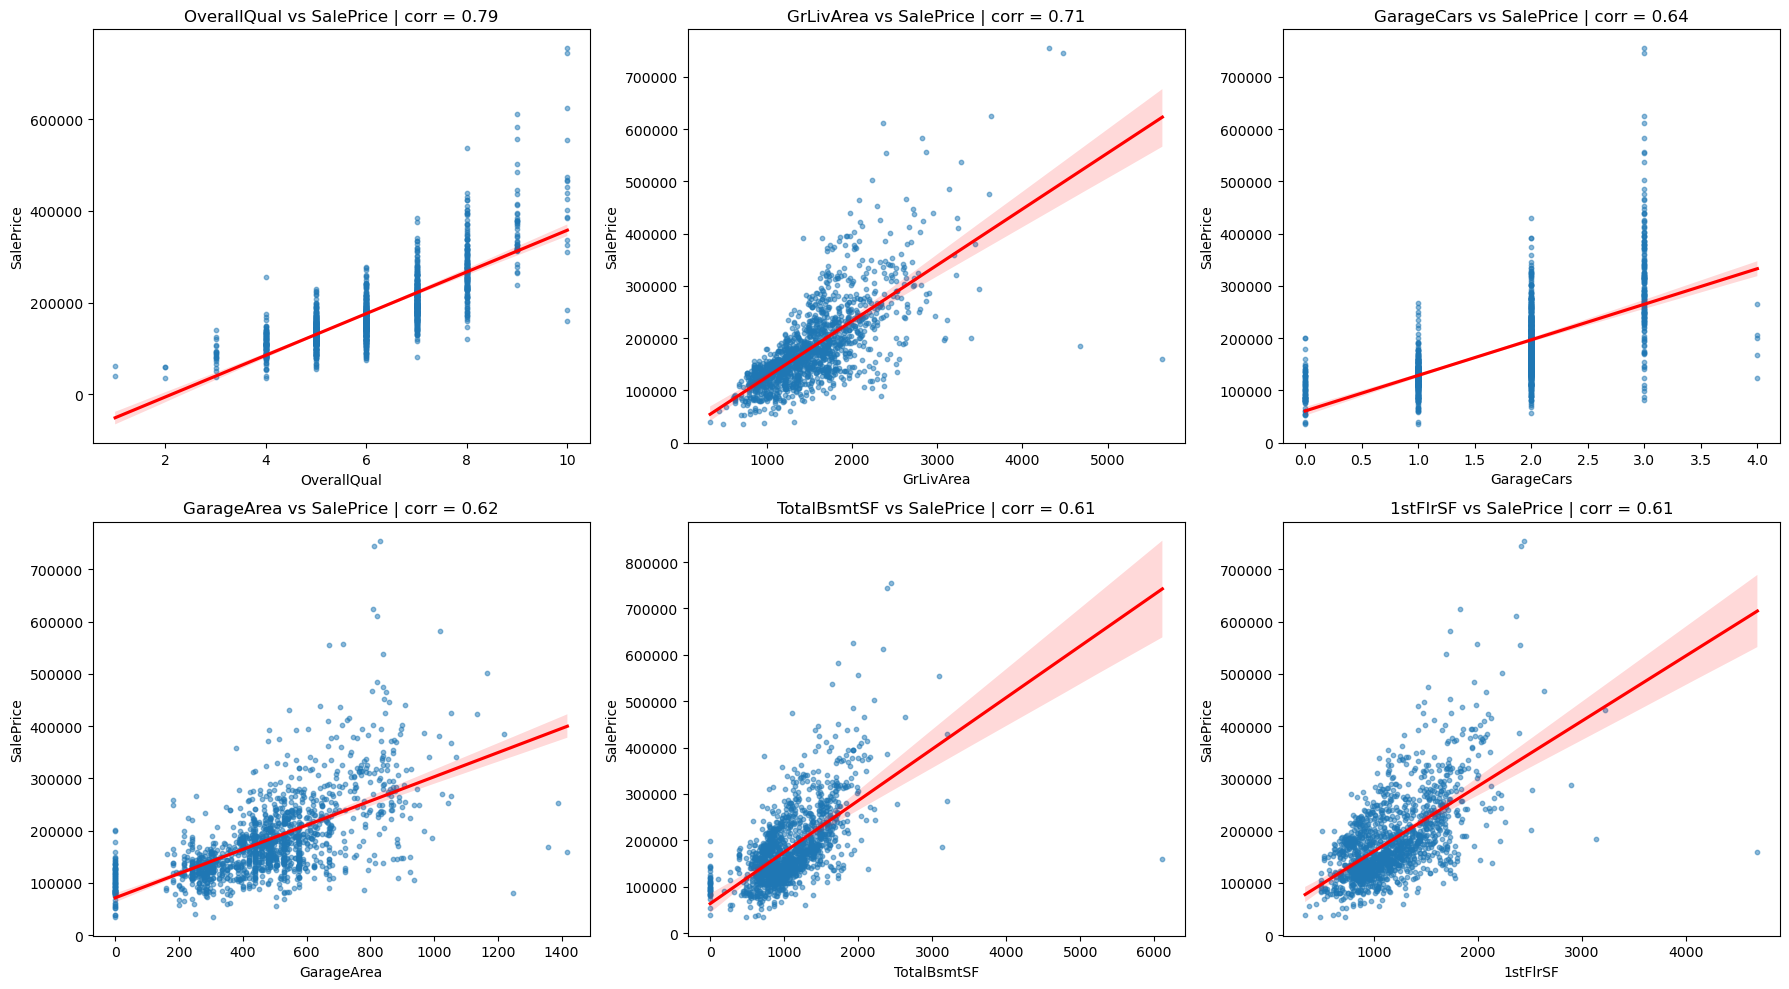

In [17]:
top6 = corr['SalePrice'].abs().sort_values(ascending=False).index.drop('SalePrice')[0:6].tolist()
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, f in enumerate(top6):
    ax = axes[i]
    sns.regplot(x=df_train[f], y=df_train['SalePrice'], scatter_kws={'s':10, 'alpha':0.5}, line_kws={'color':'red'}, ax=ax)
    ax.set_xlabel(f)
    ax.set_ylabel("SalePrice")
    corr_val = df_train[f].corr(df_train['SalePrice'])
    ax.set_title(f"{f} vs SalePrice | corr = {corr_val:.2f}")

plt.tight_layout()
plt.show()

- `GrLivArea` shows the clearest linear positive trend with SalePrice; useful predictor.  

- Some features show piecewise/tiers (e.g., OverallQual).  

- Noted outliers (e.g., GrLivArea > 4000 with low SalePrice) — inspect and decide removal or handling (cap/remove).

### Boxplot: categorical vs SalePrice

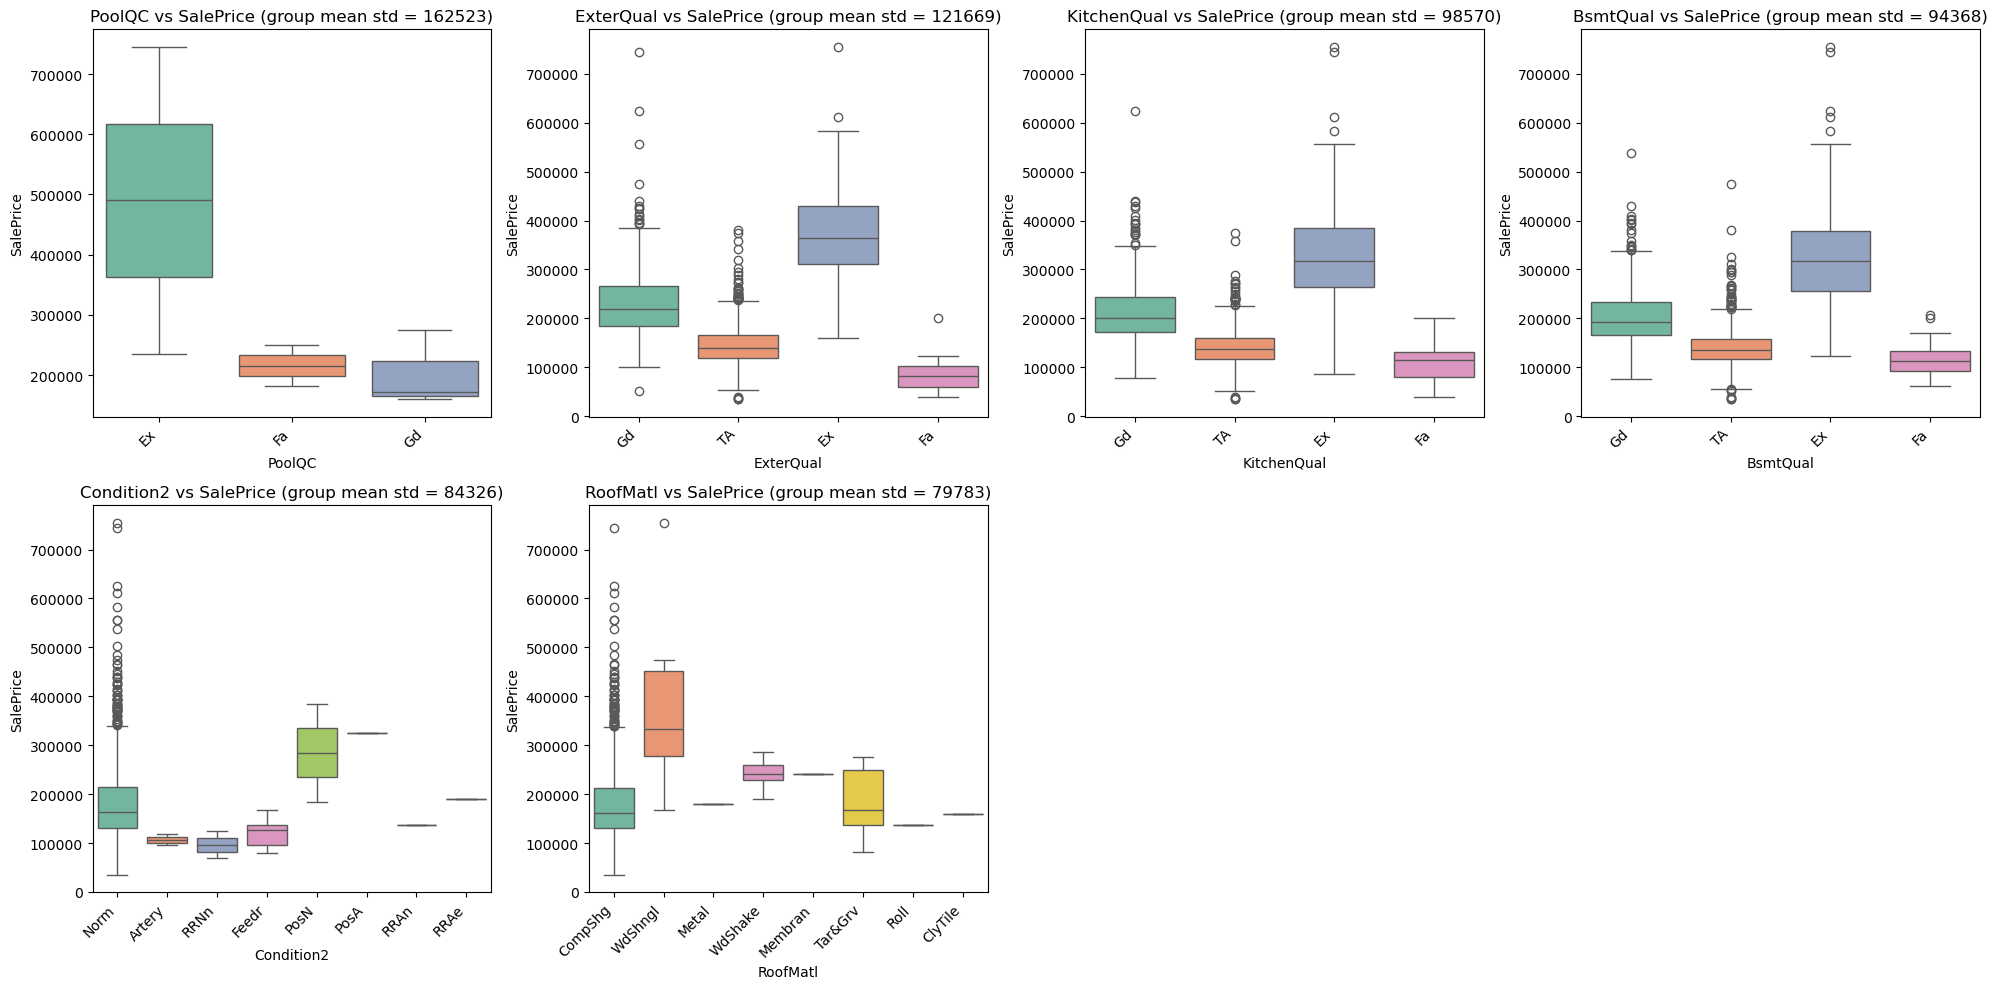

Top 10 Neighborhood that have the highest mean of SalePrice:
 Neighborhood
NoRidge    335295.317073
NridgHt    316270.623377
StoneBr    310499.000000
Timber     242247.447368
Veenker    238772.727273
Somerst    225379.837209
ClearCr    212565.428571
Crawfor    210624.725490
CollgCr    197965.773333
Blmngtn    194870.882353
Name: SalePrice, dtype: float64


In [33]:
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()

cat_score = {}
for c in cat_cols:
    grp = df_train.groupby(c)['SalePrice'].mean()
    cat_score[c] = grp.std()

top_cat = pd.Series(cat_score).sort_values(ascending=False).head(6).index.tolist()

n_cols = 4
n_rows = math.ceil(len(top_cat) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten()

for i, c in enumerate(top_cat):
    sns.boxplot(x=c, y='SalePrice', data=df_train, ax=axes[i], palette='Set2')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_title(f"{c} vs SalePrice (group mean std = {cat_score[c]:.0f})")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

nb = df_train.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False).head(10)
print("Top 10 Neighborhood that have the highest mean of SalePrice:\n", nb)

**Common abbreviations in categorical features:**

- **TA** = Typical
- **Ex** = Excellent
- **Gd** = Good
- **Av** = Average
- **Fa** = Fair
- **Po** = Poor
- **NA** = No / Not Available

- Quality variables (OverallQual, ExterQual, KitchenQual, BsmtQual) show monotonic tiers: higher quality → higher median SalePrice.

  - Treat these as ordinal (map Po→Fa→TA→Gd→Ex) rather than arbitrary strings.  

- `Neighborhood` strongly affects median price; some neighborhoods (NoRidge, NridgHt, StoneBr, ...) have much higher medians.  

  - Use special handling: group rare neighborhoods or use target encoding.  

- `HouseStyle` and other categoricals give moderate separation. 
 
- Caveat: categories with very small counts can produce unstable medians — always show count + median before acting.

## Multivariate

After understanding each pair of variables, our team moved on to see how multiple variables combined affect `SalePrice`.

### Clustered correlation heatmap

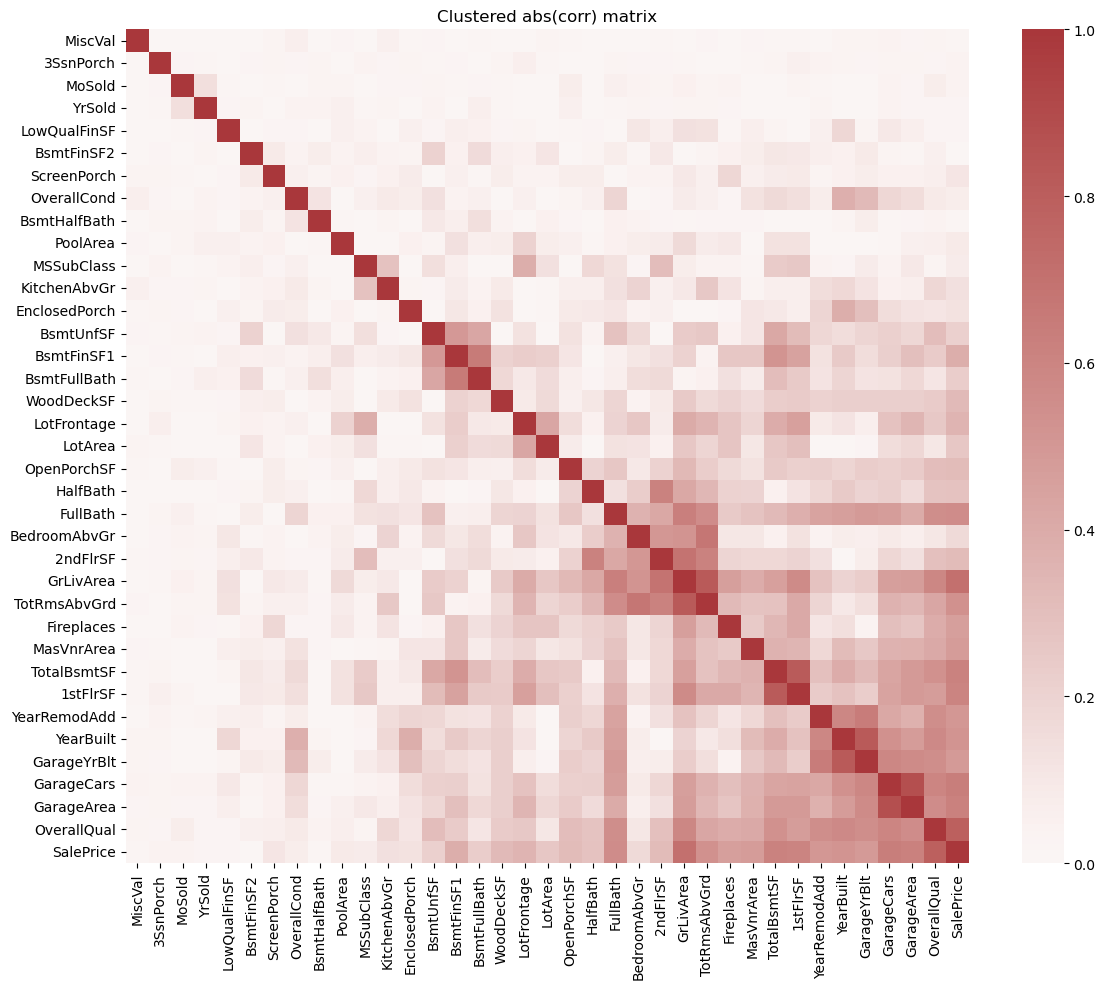

In [19]:
num = df_train.select_dtypes(include=[np.number])
corr = num.corr().abs().fillna(0)

dist = 1 - corr
condensed = squareform(dist.values)
link = sch.linkage(condensed, method='average')
idx = sch.dendrogram(link, no_plot=True)['leaves']

plt.figure(figsize=(12,10))
sns.heatmap(corr.iloc[idx, idx], cmap='vlag', center=0, vmax=1, vmin=0)
plt.title('Clustered abs(corr) matrix')
plt.tight_layout()
plt.show()

- Variables like `TotalBsmtSF`, `1stFlrSF` and `GrLivArea` form a large cluster with high correlation.

- `GarageCars` and `GarageArea` are almost identical → should only keep one in the model.

- `Overall Quality` is strongly correlated but not completely overlapping, should be a special independent perspective.

### Pairplot for top numeric features (by |corr| with SalePrice)

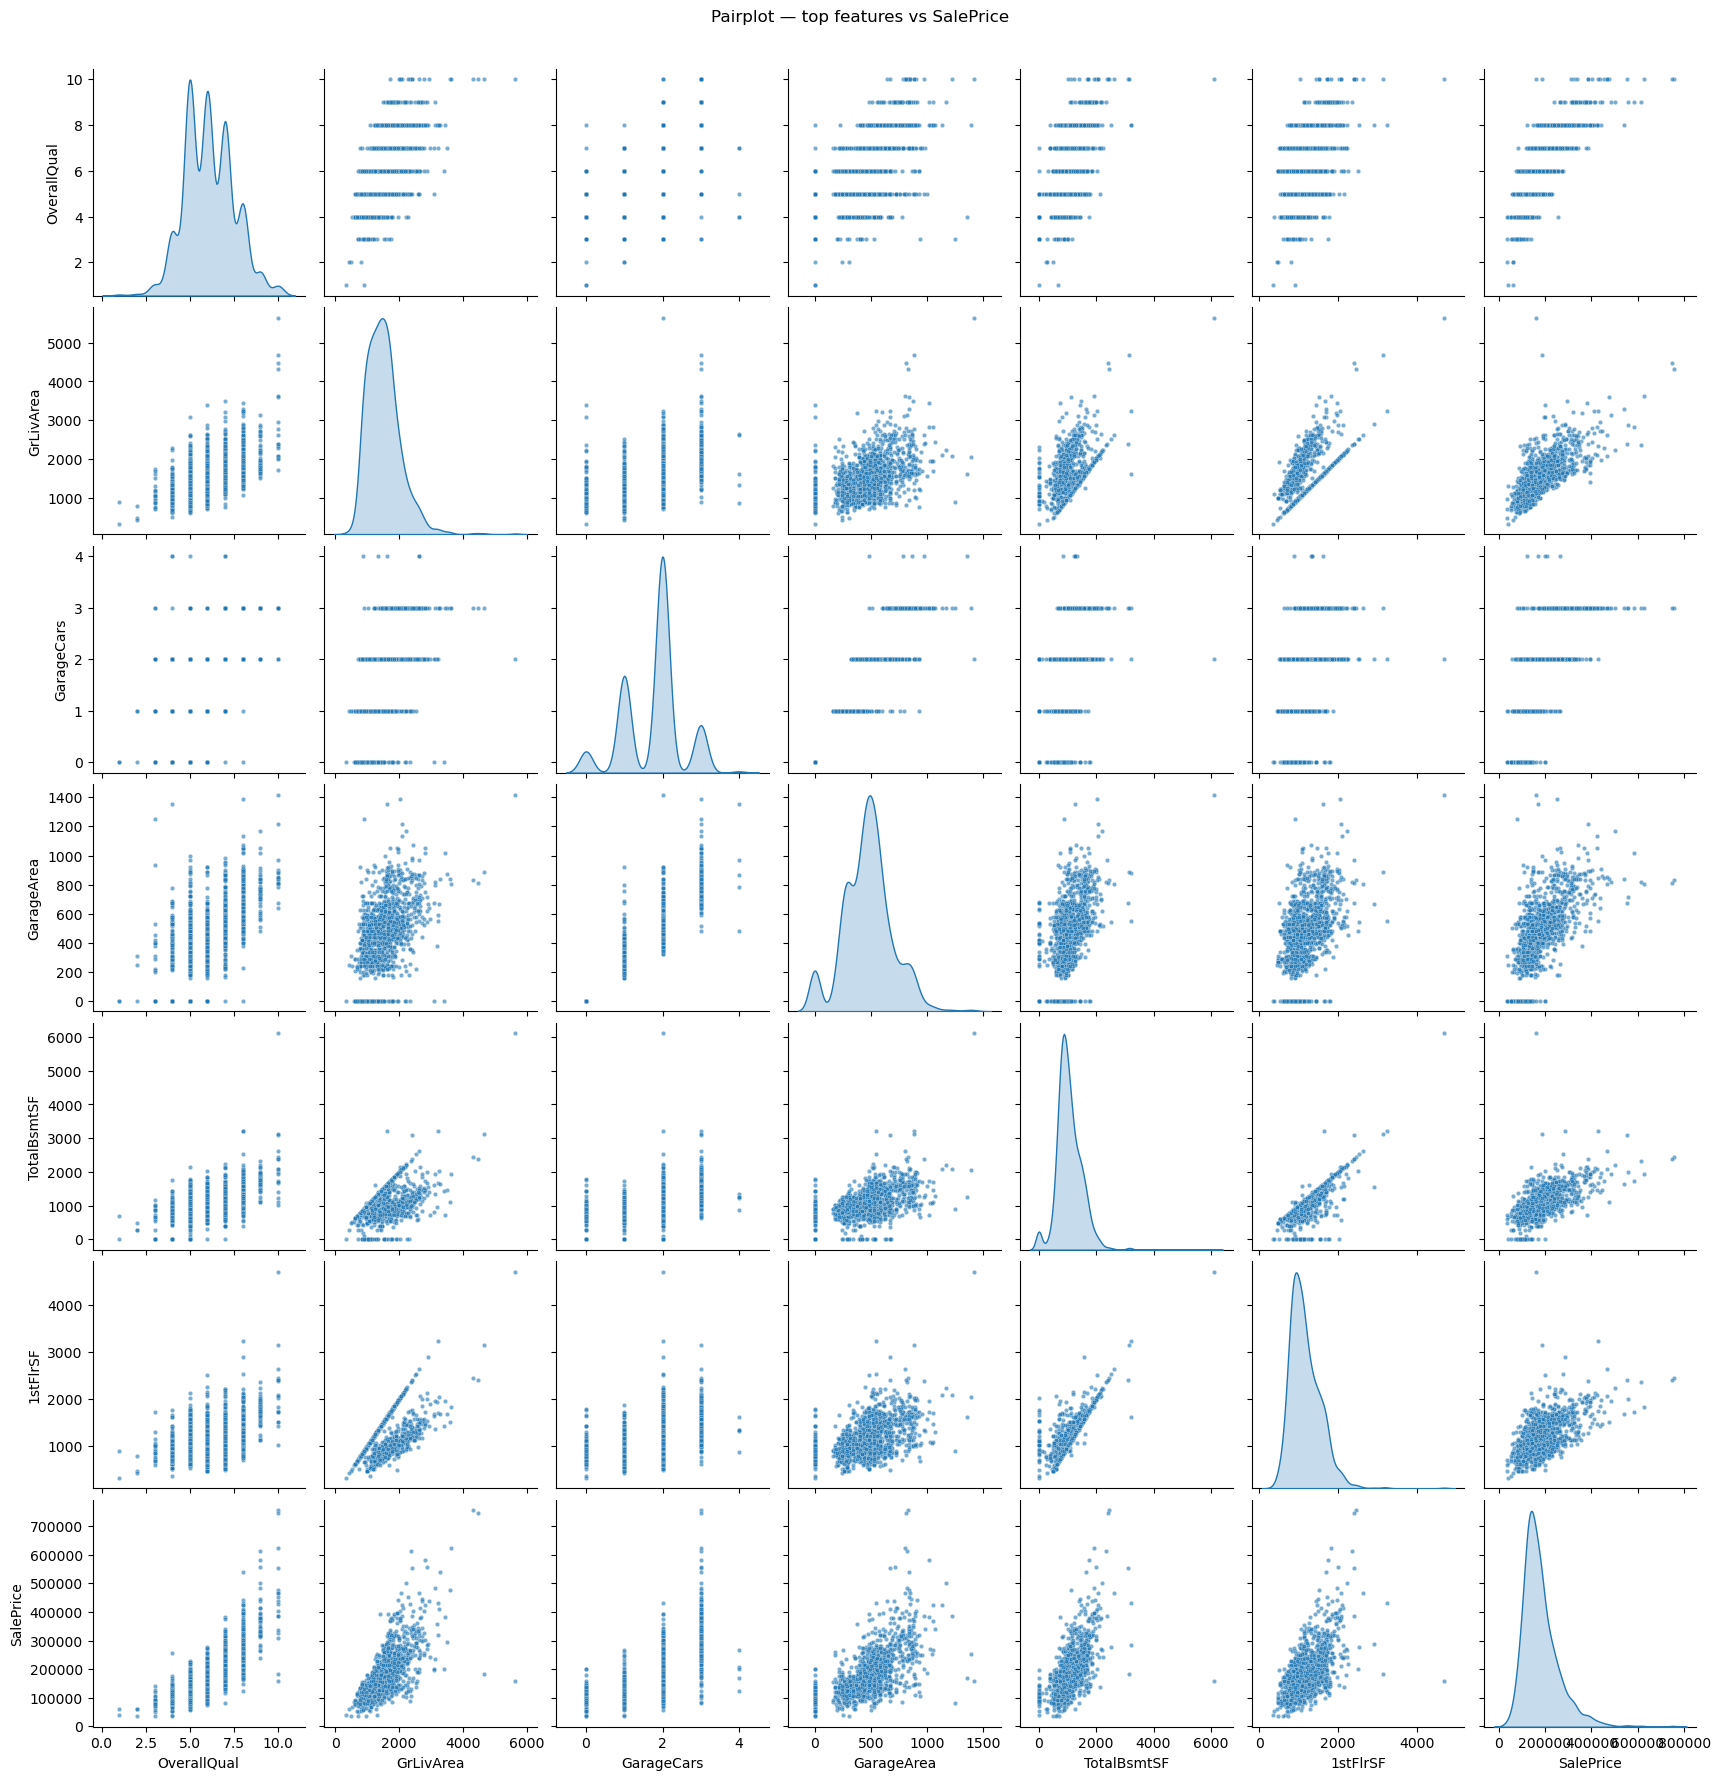

In [20]:
top_feats = num.corr()['SalePrice'].abs().sort_values(ascending=False).index.drop('SalePrice')[:6].tolist()
sns.pairplot(df_train[top_feats + ['SalePrice']], diag_kind='kde', plot_kws={'s':10, 'alpha':0.6})
plt.suptitle('Pairplot — top features vs SalePrice', y=1.02)
plt.show()

### Quick interaction check: top pairwise products correlated with SalePrice

In [21]:
num_no_target = num.drop(columns=['SalePrice'])
pairs = []
cols = num_no_target.columns.tolist()
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        prod = num_no_target[cols[i]] * num_no_target[cols[j]]
        corr_val = prod.corr(df_train['SalePrice'])
        pairs.append(((cols[i], cols[j]), abs(corr_val)))
pairs = sorted(pairs, key=lambda x: x[1], reverse=True)[:10]
print("Top interaction candidates (abs corr with SalePrice):")
for (a,b),v in pairs:
    print(f"{a} * {b}: {v:.3f}")

Top interaction candidates (abs corr with SalePrice):
OverallQual * GrLivArea: 0.832
OverallQual * GarageCars: 0.810
GrLivArea * GarageCars: 0.809
OverallQual * TotRmsAbvGrd: 0.798
OverallQual * YearBuilt: 0.796
OverallQual * YearRemodAdd: 0.795
OverallQual * YrSold: 0.791
OverallQual * GarageYrBlt: 0.791
OverallQual * GarageArea: 0.790
OverallQual * 1stFlrSF: 0.783


Some product interactions (e.g., OverallQual * GrLivArea, GarageCars * TotalBsmtSF) have high corr with SalePrice in quick check. Although the correlation values are noticable, we cannot sure that these pairs of features will benefit the accuracy of trained models. Further experiments are needed. These solutions could be used to make sure the combinations benefits the model.
- Having a strong understanding/knowledge about house pricing industry helps saving time and efforts when feature engineering
- Compare the accuracy figures between baseline model and interaction models to see improvements (e.g.: using cross validation)
- Be cautious with inter-correlation, use VIF to test it

If we combine features recklessly, it could decrease the accuracy of the model.

### Categorical vs categorical: Cramér's V heatmap

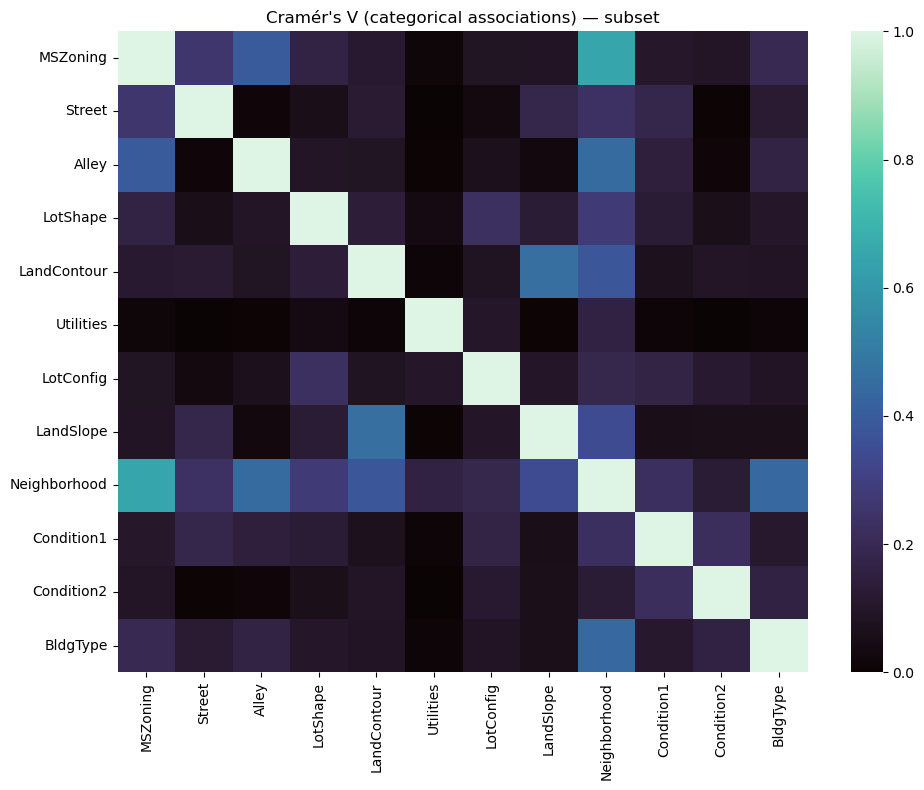

In [22]:
def cramers_v(x, y):
    ct = pd.crosstab(x, y)
    chi2 = chi2_contingency(ct, correction=False)[0]
    n = ct.sum().sum()
    phi2 = chi2 / n
    r,k = ct.shape
    return max(0, np.sqrt(phi2 / min(k-1, r-1)))
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()[:12]  # limit to first 12 for speed
cv = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
for a in cat_cols:
    for b in cat_cols:
        cv.loc[a,b] = cramers_v(df_train[a].fillna('NA'), df_train[b].fillna('NA'))
plt.figure(figsize=(10,8))
sns.heatmap(cv.astype(float), vmin=0, vmax=1, cmap='mako')
plt.title("Cramér's V (categorical associations) — subset")
plt.tight_layout()
plt.show()

- Cramér's V (subset) shows some redundant categorical pairs (e.g., Exterior1st vs Exterior2nd).  

- Action: validate with full-set checks and handle small contingency cells (add smoothing/merge rare levels) before dropping or merging features.

## Summary

- Some pairs like `Exterior1st` and `Exterior2nd` have very high correlation coefficients → choose one of the two.

- `Neighborhood` has a moderate correlation with many other features, showing that it captures independent information (which is valuable in the model).

- The quality variables (ExterQual, KitchenQual, BsmtQual) have a slight cross-linkage, showing the tendency that “a good house means a good whole”.

## Summary

Finally, our team synthesized all the findings to guide the modeling in 3 parts: 

- Most influential factors observed: `OverallQual`, `GrLivArea`, `GarageCars`/`GarageArea` (choose one), `TotalBsmtSF`, `Neighborhood`.  

- Main issues to address before modeling:

  - Right-skew target (log-transform).  
  
  - Missing data strategy (LotFrontage and several categoricals).  
  
- Next direction: Conduct **Preprocessing** to clean the data before performing feature engineering.

# The end